# Dans ce notebook le calcul des barycentre est réalisé au moyen de la méthode proposée par Puccetti dans sont article "On the computation of Wasserstein barycenters".

## Le dataset utilisé est une banque d'image inspiré du MNIST

dataset taken from transformed MNIST the  https://www.cs.toronto.edu/~tijmen/affNIST/

In [1]:
#bibliothèques
import numpy as np 
import pandas as pd
import scipy.io
import time
from PIL import Image

Importation des bibliothèques:

In [2]:
#importation
mat = scipy.io.loadmat('1.mat')
tableau = mat['affNISTdata'][0][0]
#paramêtres de l'image
nb_pixel_side = 40  #resolution = 40*40

Visualisation des données:

In [3]:
N_samples = len(tableau[2][0])

#valeurs normalisées pour obtenir une mesure de proba dans le cas général (avec nuances):
pixels_nuance = [np.array([a[i] for a in tableau[2]]) for i in range(N_samples)]
atoms_nuance = [p/sum(p) for p in pixels_nuance] # on ne va pas utiliser cette variabel, elle est uniquement informative

#liste des int qui sont écrits sur l'image:
entiers_0_9 = tableau[5][0]

In [4]:
df_im_nuance = pd.DataFrame({'pixels':pixels_nuance, 'entiers_0_9':entiers_0_9, 'atoms':atoms_nuance})
df_im_nuance.head(3)

,pixels,entiers_0_9,atoms
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


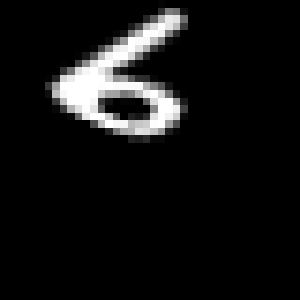

In [5]:
#%% Exemple de visualisation d'une image :
#pour l'image 40002
int_im = df_im_nuance.iloc[40002].entiers_0_9
l_pixels = df_im_nuance.iloc[40002].pixels

#dimensions de l'image
width = 40
height = 40

#display de l'image 40002
img_nuance = Image.new('L', (width, height))
img_nuance.putdata(l_pixels)
#img_nuance.save(f'image_{int_im}.png')
img_nuance.resize((300,300), resample=0)

Dans le cas de l'algo de Puccetti, les poids doivent être uniformements repartis, autrement dit il ne doit y avoir que des uns (ou des 255) et des zéros dans les matrices.
Sinon il faudrait créer une listes beaucoup plus grande qui 255-uplerait les points pour pouvoir avoir des poids ponctuels mis à repetition sur le même poids (ou alors créer 255 autres 
mesures de proba pour chacune des mesures de proba qui sont déjà dans le modèle).
Il faudra peut être étudier ce schéma, mais dans un premier temps je fais le choix de traiter un problème simplifié avec que du blanc (255) et du noir (0), que je trie grâce à un seuil

In [6]:
#nouvelles listes avec que du blanc ou du noir :
def noir_ou_blanc(nb, nb_to_compare):
    if nb < nb_to_compare:
        return(0)
    return(255)

In [7]:
pixels_BW = [np.array([noir_ou_blanc(a[i], 128) for a in tableau[2]]) for i in range(N_samples)]
atoms_BW = [p/sum(p) for p in pixels_BW] #valeurs normalisées pour obtenir une mesure de proba
   

In [8]:
df_im_BW = pd.DataFrame({'pixels':pixels_BW, 'entiers_0_9':entiers_0_9, 'atoms':atoms_BW})

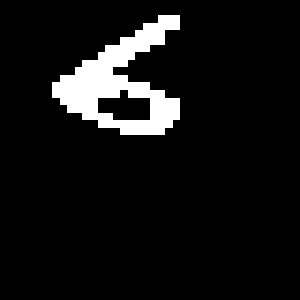

In [9]:
#%% Exemple de visualisation d'une image :
#pour l'image 40002
int_im = df_im_BW.iloc[40002].entiers_0_9
l_pixels = df_im_BW.iloc[40002].pixels

#dimensions de l'image
width = 40
height = 40

#display de l'image 40002
img_BW = Image.new('L', (width, height))
img_BW.putdata(l_pixels)
#img.save(f'image_{int_im}.png')
img_BW.resize((300,300), resample=0)

Le problème de la méthode Puccetti, c'est qu'il faut qu'exactement k des atomes soient associés à un pixel blanc donc il faut choisir le bon k

In [10]:
df_im_BW['nb_pix'] = df_im_BW.pixels.apply(lambda x: sum(x)/255)
df_im_BW.nb_pix.describe() 

count    60000.000000
mean       102.290850
std         38.771777
min         11.000000
25%         74.000000
50%         98.000000
75%        125.000000
max        362.000000
Name: nb_pix, dtype: float64

On trouve un min = 11, une mopyenne à 102 et que 75% des dessins ont au moins 74 points blancs.
On va prendre k = 70 et si des dessins ont moins de 70 pixels blanc (en terme de nuance) on élimine l'image
k = 100

# k = 60

In [11]:
k = 120

In [12]:
#cette fonction permet de ne selectionner que k pixels blanc (k plus blancs, le plus blanc étant à L=255) et laisser tous les autres pixels en noir
def white_or_black_fixed_nb(liste, k):
    k_index_255 = [np.argsort(liste)[-i] for i in range(1, k+1)]
    x = np.zeros(len(liste))
    for i in range(k):
        x[k_index_255[i]] = 255
    return(x)


In [13]:
start = time.time()
pixels = [white_or_black_fixed_nb(liste, k) for liste in pixels_nuance]
#atoms = [p/sum(p) for p in pixels] #valeurs normalisées pour obtenir une mesure de proba uniforme

end = time.time()
print(end - start, " secondes pour executer l'importation et le prétraitement des matrices")

100.88133931159973  secondes pour executer l'importation et le prétraitement des matrices


In [14]:
df_im_k_BW = pd.DataFrame({'pixels':pixels, 'entiers_0_9':entiers_0_9}) #, 'atoms':atoms})

In [15]:
df_im_k_BW.iloc[0].pixels.sum()/255

120.0

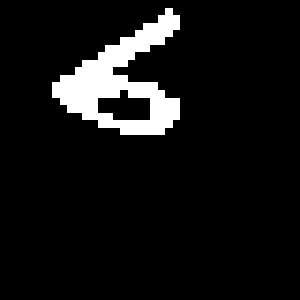

In [16]:
#%% Exemple de visualisation d'une image :
#pour l'image 40002
int_im = df_im_k_BW.iloc[40002].entiers_0_9
l_pixels = df_im_k_BW.iloc[40002].pixels

#dimensions de l'image
width = 40
height = 40

#display de l'image 40002
img_k_BW = Image.new('L', (width, height))
img_k_BW.putdata(l_pixels)
#img.save(f'image_{int_im}.png')
img_k_BW.resize((300,300), resample=0)

Visualisation de n mesures de probabilité.
I.e superposition de n dessins:

#### 1) En considérant des proba générales, i.e avec des nuances de gris

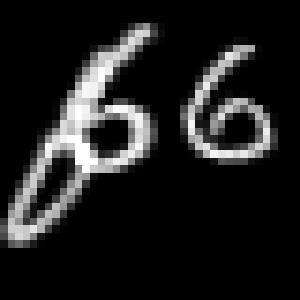

In [17]:
#selection du chiffre à superposer

def image_superimposed(number, nb_of_images, df_im):
    df_im_c = df_im.loc[df_im.entiers_0_9 == number].head(nb_of_images)

    #display de l'image 
    l_pixels = [0] * N_samples
    img_superimposed = Image.new('L', (width, height))
    for l_c in df_im_c.pixels:
        l_pixels = [x + y for x, y in zip(l_pixels, l_c)]
    img_superimposed.putdata(l_pixels)
    return(img_superimposed)

c = 6
n = 3
#img_superimposed.save(f'{n}_N&B_images_superimposed_of_{c}.png')
image_superimposed(c, n, df_im_nuance).resize((300,300), resample=0)

#### 2) Mais puisque nous ne considerons pas les nuances de gris car les probabilités sont uniformes:

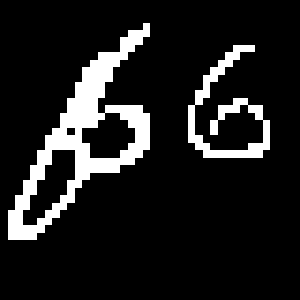

In [18]:
#avec L > 128
c = 6
n = 3
image_superimposed(c, n, df_im_BW).resize((300,300), resample=0)

Avec une selection avec seuil (si L>128 le pixel est blanc)

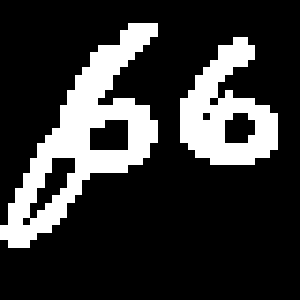

In [19]:
#avec k pixels blancs
c = 6
n = 3
image_superimposed(6, n, df_im_k_BW).resize((300,300), resample=0)

En ne selectionnant que les k pixels les plus blancs pour les mettre à blanc 255, les autre en noir 0.

On remarque que cette hypothèse est déjà une approximation.
Il est possible de rendre compte des nuances de gris en affectant des probabilités uniformes à des éléments répetés mais cela signifierai que pour chaque mesure de probabilités il faudrait nb_nuance*pixels = 255*16000 données, ce qui rend l'étude plus coûteuse numériquement.

# Essayons de trouver le barycentre dans le cas du chiffre c.

## Prenons n = 4 mesures de probabilités

### Rappel : La dimension des atomes est d =40*40 = 1600

In [20]:
entier = 6
df_work = df_im_k_BW.loc[df_im_k_BW.entiers_0_9==entier]
df_work.shape

(5918, 2)

In [21]:
n = 5
k= 100
df_work = df_work.iloc[:n] 
d = len(df_work.iloc[0].pixels)
n

5

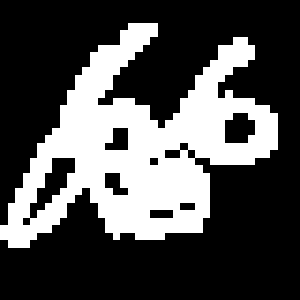

In [22]:
image_superimposed(entier, n, df_im_k_BW).resize((300,300), resample=0)

In [23]:
df_im_k_BW.columns

Index(['pixels', 'entiers_0_9'], dtype='object')

Dans un premier temps il faut diviser notre images en k atoms, c'est à dire img = (0,1,0,1,1) donne atoms = [(0,1,0,0,0), (0,0,0,1,0,0), (0,0,0,0,1)]
Cela revient à décomposer ce vecteur sur la base canonique R^k

In [24]:
df_work.columns

Index(['pixels', 'entiers_0_9'], dtype='object')

In [25]:
x_base1600 = []
for i in range(n):
    x_base1600.append([])
    l_pixels = df_work.pixels.iloc[i]
    index_255 = [i for i in range(len(l_pixels)) if l_pixels[i]==255]
    for j in range(k):
        x_ij = np.zeros(d)
        x_ij[index_255[j]] = 1
        x_base1600[i].append(x_ij)

La liste de listes x contient tous les atomes de toutes les mesures de probabilité. 

x[i][j] correspond à l'atome j de la mesure de probabilité i.

Je pense qu'il faut remplacer chaque atomes (dx1) (40²x1) par un atome qui ne comporte que la position géométrique de l'atome d'origine (donc en 2x1) car on va voilour trouver un barycentre géométrique des groupes d'atomes formés, dans un second temps.
La transformation est la suivant:

In [26]:
def to_base_can(x_ij, nb_pixel_side):
    location_1 = np.argsort(x_ij)[-1]
    new_x = location_1 // nb_pixel_side
    new_y = location_1 - new_x * nb_pixel_side
    x_ij = np.array([new_x, new_y])
    return(x_ij)

#boucle sur tous les atomes de toutes les lois pour avoir tous les atomes en base canonique ((0,1), (1,0))
x = []
for i in range(n):
    x.append([])
    for j in range(k):
        x[i].append(to_base_can(x_base1600[i][j], nb_pixel_side))

L'article de Puccetti utilise un algorithme itératif qui consiste à comparer le côté droit d'une inequation avec le côté gauche et dans le cas où left_side < right_side, les éléments x[i][k1] et x[i][k2] sont échangés.

In [27]:
#comparaison de Puccetti :
start_pucc = time.time()
for i in range(n):
    #print(i, 'temps en secondes: ' time.time() - start_pucc) #temps
    for k1 in range(k-1):
        for k2 in range(k1+1,k):
            left_side = np.dot(x[i][k1], sum([x[j][k1] for j in range(n) if j!=i])) + np.dot(x[i][k2], sum([x[j][k2] for j in range(n) if j!=i]))
            right_side = np.dot(x[i][k1], sum([x[j][k1] for j in range(n) if j!=i])) + np.dot(x[i][k2], sum([x[j][k2] for j in range(n) if j!=i]))
            if left_side < right_side:
                copy_xik1 = x[i][k1].copy()
                x[i][k1] = x[i][k2]
                x[i][k2] = copy_xik1
end_pucc = time.time()
print(end_pucc - start_pucc, f" secondes pour executer l'algorithme de comparaison de Puccetti pour {n} mesures de probabilités empiriques et {k} atomes par mesure")     

0.5910279750823975  secondes pour executer l'algorithme de comparaison de Puccetti pour 5 mesures de probabilités empiriques et 100 atomes par mesure


A partir de ce moment là, tous les atomes des mesures de probabilités sont triés atoms_mui = [xi1, xi2, xi3,...,xik] --> atoms_mui = [xi3, xi5, xi1,...,xi2] par exemple

### Remarque: on voit bien dans la construction de l'algorithme que sa complexité est en O(nk²)

Il reste maintenant à trouver les k atomes de la loi barycentriques des mesures de probabilités.

Ces atomes sont en fait le barycentre des regroupement formés grâce à l'algorithme présedent, de sorte que: 

x_mu_barycentrique_j = barycentre(x[i,j] for j in [1,n]), j dans [1,k]. Ce barycentre peut se calculer comme une moyenne empirique. 

In [28]:
x_barycenter = []
for j in range(k):
    x_barycenter.append(sum([x[i][j] for i in range(n)])/n)

Grâce à l'inverse de to_base_can() on reconstruit l'image

In [29]:
def inv_to_base_can(x_ij, nb_pixel_side):
    x = np.zeros(nb_pixel_side*nb_pixel_side)
    location_1 = int(x_ij[0]) * nb_pixel_side + int(x_ij[1]) #j'arrondis à la partie entière
    #and NOT " loc_pix = int(np.round(x_ij[0]) * nb_pixel_side + np.round(x_ij[1])) " that is less precise
    x[location_1] = 1
    return(x)

x_barycenter_base1600 = [inv_to_base_can(x, nb_pixel_side) for x in x_barycenter]

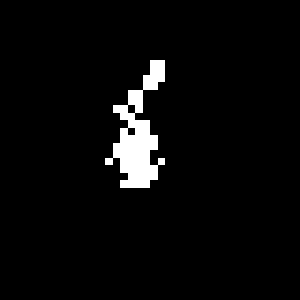

In [30]:
#%% Visualisation du résultat:
pixel_resultat = sum(x_barycenter_base1600)*255

#dimensions de l'image
width = 40
height = 40
#display de l'image 40002
img_res = Image.new('L', (width, height))
img_res.putdata(pixel_resultat)
img_res.save(f'image_result_nck_{n}_{entier}_{k}.png')
img_res.resize((300,300), resample=0)

# Essaie avec des images plus simples

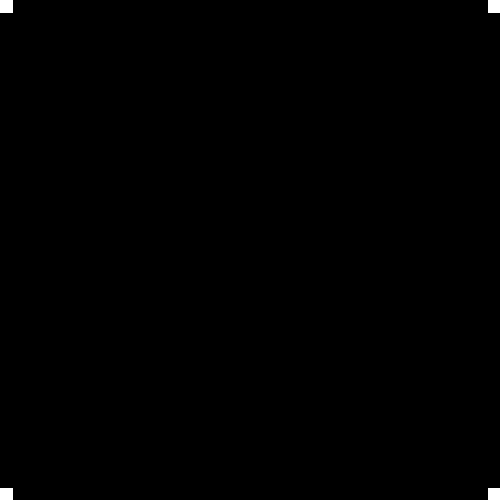

In [31]:
#création de 4 images
x1 = np.zeros(nb_pixel_side**2)
x2, x3, x4, x5 = x1.copy(), x1.copy(), x1.copy(), x1.copy()

x1[0] = 255
x2[nb_pixel_side-1] = 255
x3[nb_pixel_side*(nb_pixel_side-1)] = 255
x4[nb_pixel_side*nb_pixel_side-1] = 255
x5[nb_pixel_side*nb_pixel_side//2 + 10] = 255

x_base1600_simple = [x1, x2, x3, x4] #, x5]

#display de l'image 
x_pix = sum(x_base1600_simple)
img_superimposed = Image.new('L', (width, height))
img_superimposed.putdata(x_pix)
img_superimposed.resize((500,500), resample=0)

0.0  secondes pour executer l'algorithme de comparaison de Puccetti pour 2 mesures de probabilités empiriques et 2 atomes par mesure
image_result_nck_2_6_2 :


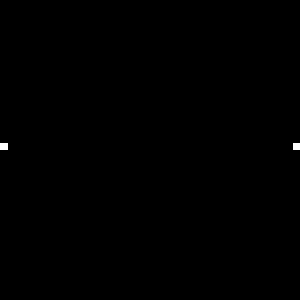

In [32]:
#x_base1600 = [[x] for x in x_base1600_simple]
#En groupant des images entre elles:
x_base1600 =  [[x1, x2], [x3, x4]] 
k = len(x_base1600[0])
n = len(x_base1600)


def to_base_can(x_ij, nb_pixel_side):
    location_1 = np.argsort(x_ij)[-1]
    new_x = location_1 // nb_pixel_side
    new_y = location_1 - new_x * nb_pixel_side
    x_ij = np.array([new_x, new_y])
    return(x_ij)

#boucle sur tous les atomes de toutes les lois pour avoir tous les atomes en base canonique ((0,1), (1,0))
x = []
for i in range(n):
    x.append([])
    for j in range(k):
        x[i].append(to_base_can(x_base1600[i][j], nb_pixel_side))
        
#comparaison de Puccetti :
start_pucc = time.time()
for i in range(n):
    #print(i, 'temps en secondes: ' time.time() - start_pucc) #temps
    for k1 in range(k-1):
        for k2 in range(k1+1,k):
            left_side = np.dot(x[i][k1], sum([x[j][k1] for j in range(n) if j!=i])) + np.dot(x[i][k2], sum([x[j][k2] for j in range(n) if j!=i]))
            right_side = np.dot(x[i][k1], sum([x[j][k1] for j in range(n) if j!=i])) + np.dot(x[i][k2], sum([x[j][k2] for j in range(n) if j!=i]))
            if left_side < right_side:
                copy_xik1 = x[i][k1].copy()
                x[i][k1] = x[i][k2]
                x[i][k2] = copy_xik1
end_pucc = time.time()
print(end_pucc - start_pucc, f" secondes pour executer l'algorithme de comparaison de Puccetti pour {n} mesures de probabilités empiriques et {k} atomes par mesure") 

x_barycenter = []
for j in range(k):
    x_barycenter.append(sum([x[i][j] for i in range(n)])/n)
    
def inv_to_base_can(x_ij, nb_pixel_side):
    x = np.zeros(nb_pixel_side*nb_pixel_side)
    location_1 = int(x_ij[0]) * nb_pixel_side + int(x_ij[1]) #j'arrondis à la partie entière
    x[location_1] = 1
    return(x)

x_barycenter_base1600 = [inv_to_base_can(x, nb_pixel_side) for x in x_barycenter]


#%% Visualisation du résultat:
pixel_resultat = sum(x_barycenter_base1600)*255

#dimensions de l'image
width = 40
height = 40
#display de l'image 40002
img_res = Image.new('L', (width, height))
img_res.putdata(pixel_resultat)
#img_res.save(f'image_result_nck_{n}_{c}_{k}.png')
print(f'image_result_nck_{n}_{c}_{k} :')
img_res.resize((300,300), resample=0)